In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from typing import Tuple

In [2]:
def load_generators_train(dataset_dir: str, image_dim: Tuple[int, int], batch_size: int):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        shuffle=True,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_dim,
        batch_size=batch_size)
    # it takes input images and outputs augmented images

    print('created dataset for {}'.format(dataset_dir))

    return train_generator

In [3]:
def load_generators_val(dataset_dir: str, image_dim: Tuple[int, int], batch_size: int):
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        shuffle=False,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_dim,
        batch_size=1)
    print('created dataset for {}'.format(dataset_dir))

    return train_generator

In [4]:
BATCH_SIZE = 24
IMG_HEIGHT = 299
IMG_WIDTH = 299

train_dir = '/kaggle/input/coffee-dataset/coffee-datasets/symptom/train'
validation_dir = '/kaggle/input/coffee-dataset/coffee-datasets/symptom/val'

# load the data generators
train_datagen = load_generators_train(train_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)

validation_datagen = load_generators_val(validation_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)
#These new datasets are new transformed images produced using ImageDataGenerator class required for transfer learning.

Found 1539 images belonging to 5 classes.
created dataset for /kaggle/input/coffee-dataset/coffee-datasets/symptom/train
Found 335 images belonging to 5 classes.
created dataset for /kaggle/input/coffee-dataset/coffee-datasets/symptom/val


In [5]:
INCEPTIONV3_TFHUB = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
#Getting the InceptionV3 model

In [6]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
num_classes = train_datagen.num_classes
#declaring the classes and input shape

# fetch the feature extractor from the tf_hub
feature_extractor = hub.KerasLayer(INCEPTIONV3_TFHUB, input_shape=input_shape)
#used to gather the transfer learning model

# make the feature extractor trainable
feature_extractor.trainable = True
# create the sequential model
model = tf.keras.Sequential([
    feature_extractor, 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])

In [7]:
# print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
# compiling the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005,momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# training the model
history=model.fit(
    train_datagen,
    epochs=12,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=validation_datagen)

Train for 64 steps, validate for 335 steps
Epoch 1/12
64/64 [==============================] - 36s 566ms/step - loss: 0.8175 - accuracy: 0.7762 - val_loss: 2.9752 - val_accuracy: 0.3582
Epoch 2/12
64/64 [==============================] - 21s 323ms/step - loss: 0.4059 - accuracy: 0.9512 - val_loss: 0.9999 - val_accuracy: 0.7701
Epoch 3/12
64/64 [==============================] - 20s 320ms/step - loss: 0.2888 - accuracy: 0.9861 - val_loss: 0.5173 - val_accuracy: 0.9224
Epoch 4/12
64/64 [==============================] - 20s 319ms/step - loss: 0.2456 - accuracy: 0.9974 - val_loss: 0.5181 - val_accuracy: 0.9403
Epoch 5/12
64/64 [==============================] - 24s 378ms/step - loss: 0.2371 - accuracy: 1.0000 - val_loss: 0.4082 - val_accuracy: 0.9552
Epoch 6/12
64/64 [==============================] - 20s 319ms/step - loss: 0.2362 - accuracy: 0.9993 - val_loss: 0.3901 - val_accuracy: 0.9642
Epoch 7/12
64/64 [==============================] - 20s 319ms/step - loss: 0.2357 - accuracy: 1.000

In [10]:
# evaluate the model
loss, accuracy = model.evaluate(validation_datagen)
# train accuracy
train_loss, train_accuracy = model.evaluate(train_datagen)

65/65 [==============================] - 5s 74ms/step - loss: 0.2347 - accuracy: 0.9994


In [11]:
"Trained Model for {} epochs, train accuracy: {:5.2f}%, test accuracy: {:5.2f}%".format(2, 100*train_accuracy, 100*accuracy)

'Trained Model for 2 epochs, train accuracy: 99.94%, test accuracy: 97.01%'

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
Y_pred = model.predict(validation_datagen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
matrix=confusion_matrix(validation_datagen.classes, y_pred)
print(matrix)

Confusion Matrix
[[40  0  0  0  0]
 [ 0 80  0  1  2]
 [ 0  0 90  0  3]
 [ 0  1  0 68  1]
 [ 0  1  1  0 47]]


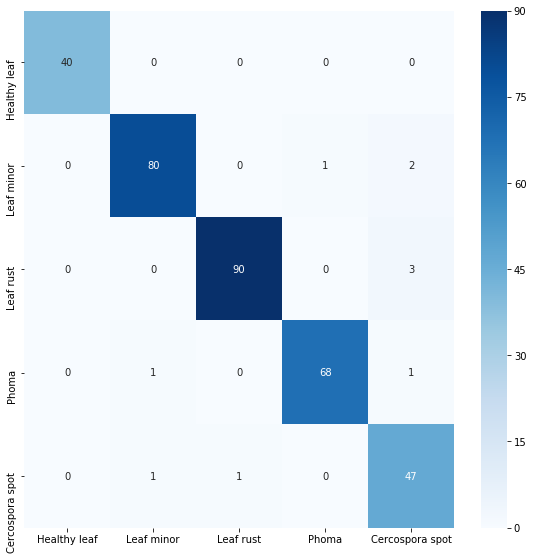

In [15]:
import matplotlib.pyplot as plt 
labels=['Healthy leaf','Leaf minor','Leaf rust','Phoma','Cercospora spot']
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix,annot=True,cmap=plt.cm.Blues,xticklabels=labels,yticklabels=labels)
plt.tight_layout()
plt.show()